In [79]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [80]:
# Чтение фреймов зарплат
df2000_2016 = pd.read_excel('/content/tab3_zpl_2023.xlsx', sheet_name=1, header=2, usecols='A:R', nrows=35)
df2000_2016.iloc[:, 0] = [x.lower().strip() for x in df2000_2016.iloc[:, 0]]
# df2000_2016.tail()
df2017_2023 = pd.read_excel('/content/tab3_zpl_2023.xlsx', sheet_name=0, header=4, usecols='A:H', nrows=53)
df2017_2023.iloc[:, 0] = [x.lower().strip() for x in df2017_2023.iloc[:, 0]]
# df2017_2023.head()
#Объединение
df2000_2016.set_index('Unnamed: 0', inplace=True)
df2017_2023.set_index('Unnamed: 0', inplace=True)
df = df2000_2016.join(df2017_2023, lsuffix='_left', rsuffix='_right', how='outer').reset_index()
# Переименование названий столбцов
df.columns = ['Вид деятельности']+[x for x in range(2000, 2024)]

Выбранные виды деятельности:
- добыча полезных ископаемых;
- образование;
- строительство.

In [81]:
def plt_settings(x, text):
    plt.xticks(np.arange(min(x), max(x)+1, 1.0))
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.legend()
    plt.xlabel('Годы') #Подпись для оси х
    plt.ylabel('Среднемесячная З/П в рублях') #Подпись для оси y
    plt.title(text) #Название
    plt.show()


Отрицательное изменение: вид деятельности - "строительство". В 2009 году.


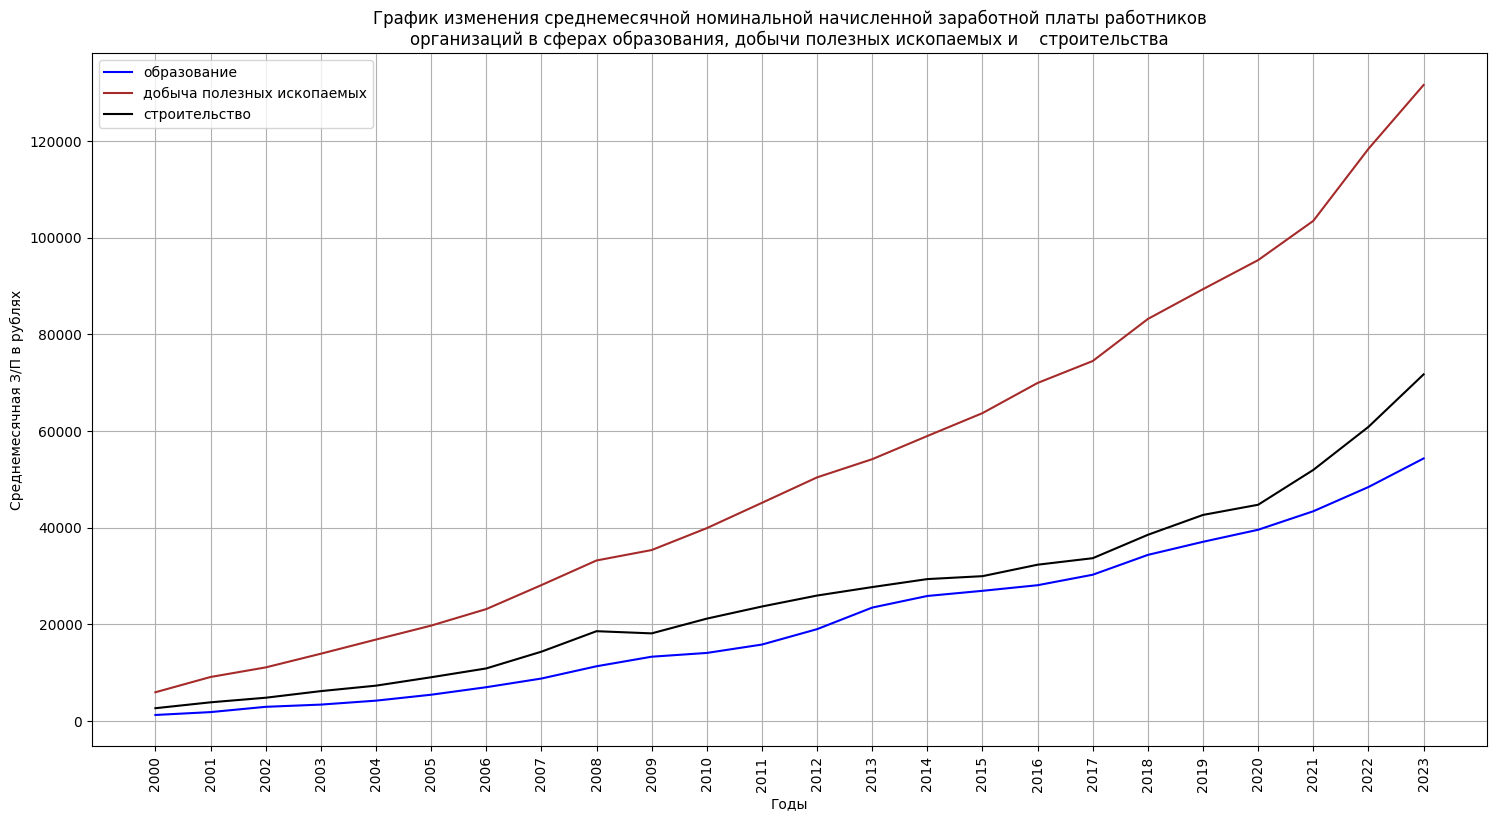

In [82]:
# Графики
plt.figure(figsize=(18,9))
labels = ('образование', 'добыча полезных ископаемых', 'строительство')
colors = ('blue', 'brown', 'black')
#Список годов 2000 - 2023
x = df.columns[1:]
for i in range(3):
    y = df.loc[df['Вид деятельности'] == labels[i]].iloc[0][1:]
    plt.plot(x, y, color=colors[i], label=labels[i])
    for j in range(1, len(x)-1):
        if y.iloc[j] < y.iloc[j-1]:
            print(f'Отрицательное изменение: вид деятельности - "{labels[i]}". В {x[j]} году.')

plt_settings(x, 'График изменения среднемесячной номинальной начисленной заработной платы работников\nорганизаций в сферах образования, добычи полезных ископаемых и\
    строительства')

Выводы:
- изменение всех среднемесячных номинальных З/П имеет выраженную положительную тенденцию;
- самый быстрый рост наблюдался в сфере добычи полезных ископаемых;
- отрицательное изменение зафиксированно только один раз - для вида деятельности "строительство" в 2009 году.

In [83]:
# чтение фрейма инфляции
df_inf = pd.read_excel('/content/infl.xlsx', usecols='A,N', nrows=24, skiprows=[1])
# Разворот фрейма
myseries_index = df_inf.index
df_inf = df_inf.iloc[::-1]
df_inf.index = myseries_index

При анализе реальных среднемесячных З/П большое значение имеет выбор года, рубли которого принимаются за базовые - среднемесячные З/П за другие периоды выражаются через эти "базовые" рубли.

Формулы расчета коэффициентов для пересчета З/П с поправкой на инфляцию:

[1] Kn = Kn-1 * (100 - pn)/100,

[2] K0 = (100 - p0)/100,

где

K0 - коэффициент для года, считающегося базовым (через рубли этого года будут выражены остальные З/П);

Kn (n != 0) - коэффициенты для пересчета З/П для годов, отличных от базового;

pn - коэффициенты инфляции из фрейма данных.

Если в качестве базового года (с индексом "0") выбран не первый год выборки (2000), то коэффициенты для пересчета З/П с поправкой на инфляцию находятся благодаря "перевороту" формулы [1]:

[3] Kn-1 = Kn * 100 / (100 - pn).

Реальная среднемесячная З/П (в рублях базового года) за конкретный год получется путем перемножения значения среднемесячной номинальной начисленной заработной платы и соотетстветствующего коэффициента К.



In [84]:
# Создание фрейма данных коэффициентов К
df_infl_koefs = pd.DataFrame(columns=df.columns[1:])
df_infl_koefs.loc['koefs'] = [0]*len(df.iloc[0][1:])
# Год, принимаемый за базовый
base_year = 2016
# Заполнение фрейма данных коэффициентов К
base_year_col_position_in_dataframe = df_infl_koefs.columns.get_loc(base_year)
# Up
k = 1
for i in range(base_year_col_position_in_dataframe, len(df.iloc[0][1:])):
    k *= (100 - df_inf['Всего'][i])/100.0
    df_infl_koefs.at['koefs', df_infl_koefs.columns[i]] = k
# Down
k = df_infl_koefs.loc['koefs'].iloc[base_year_col_position_in_dataframe]
for i in range(base_year_col_position_in_dataframe - 1, -1, -1):
    k /= (100 - df_inf['Всего'][i])/100.0
    df_infl_koefs.at['koefs', df_infl_koefs.columns[i]] = k

df_infl_koefs = df_infl_koefs.T

In [85]:
# Чтение фрейма безработицы
df_unemployment = pd.read_excel('/content/ind_dtr_2024.xlsx', header=8, usecols='B:W', nrows=3)
df_unemployment.columns = [x for x in range(2001, 2023)]
df_unemployment = df_unemployment.T

Корелляция изменения реальной З/П (в рублях 2016-го года) для вида деятельности
"образование" с уровнем безработицы общей, мужской, женской соответсвенно:
-0.88,  -0.86,  -0.90
Отрицательное изменение реальной З/П для вида деятельности
"образование" зафиксированно в следующих годах:
2003,  2010,  2015,  2016,  2022.
Корелляция изменения реальной З/П (в рублях 2016-го года) для вида деятельности
"добыча полезных ископаемых" с уровнем безработицы общей, мужской, женской соответсвенно:
-0.89,  -0.87,  -0.91
Отрицательное изменение реальной З/П для вида деятельности
"добыча полезных ископаемых" зафиксированно в следующих годах:
2002,  2009,  2015,  2016,  2021.
Корелляция изменения реальной З/П (в рублях 2016-го года) для вида деятельности
"строительство" с уровнем безработицы общей, мужской, женской соответсвенно:
-0.78,  -0.74,  -0.82
Отрицательное изменение реальной З/П для вида деятельности
"строительство" зафиксированно в следующих годах:
2009,  2013,  2014,  2015,  2016,  2020.


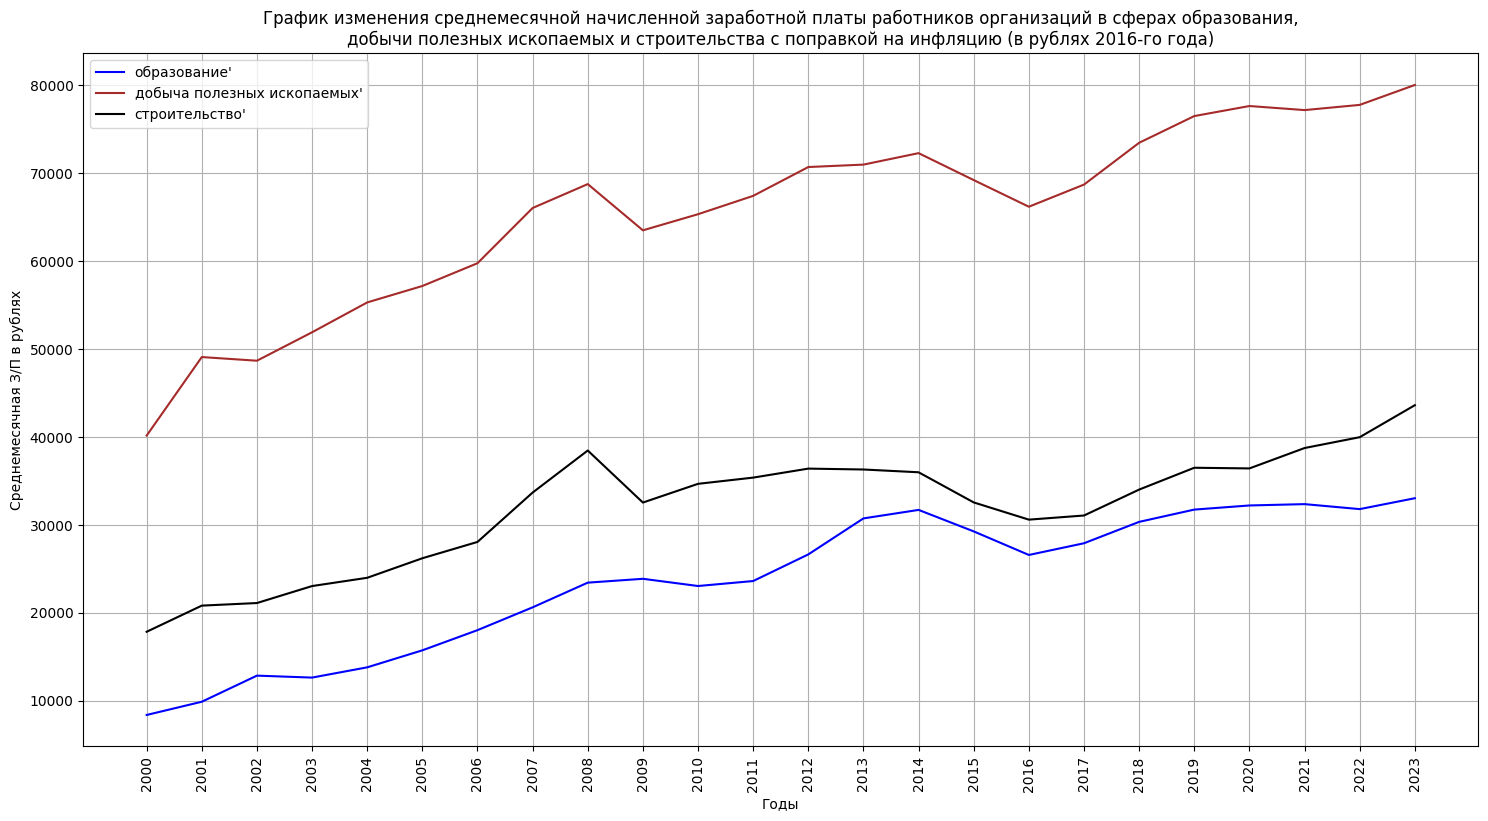

In [86]:
# Графики
plt.figure(figsize=(18,9))
labels = ('образование', 'добыча полезных ископаемых', 'строительство')
colors = ('blue', 'brown', 'black')
#Список годов 2000 - 2023
x = df.columns[1:]
for i in range(3):
    y = df.loc[df['Вид деятельности'] == labels[i]].iloc[0][1:].mul(df_infl_koefs['koefs'])
    plt.plot(x, y, color=colors[i], label=labels[i]+'\'')
    # Рассчет корелляций
    pirson_koef_unemp = []
    for row in range(3):
        pirson_koef_unemp.append(format(df_unemployment[row].astype(float).corr(y[1:-1].astype(float)), ".2f"))
    print(f'Корелляция изменения реальной З/П (в рублях {base_year}-го года) для вида деятельности\n"{labels[i]}" с уровнем безработицы общей, мужской, женской соответсвенно:\n{",  ".join(pirson_koef_unemp)}')
    negative_change_years = []
    for j in range(1, len(y)-1):
        if y.iloc[j] < y.iloc[j-1]:
            negative_change_years.append(str(x[j]))
    if negative_change_years:
        print(f'Отрицательное изменение реальной З/П для вида деятельности\n"{labels[i]}" зафиксированно в следующих годах:\n{",  ".join(negative_change_years)}.')
    else:
        print(f'Отрицательное изменение реальной З/П не зафиксированно')

plt_settings(x, f'График изменения среднемесячной начисленной заработной \
платы работников организаций в сферах образования,\nдобычи полезных ископаемых и\
 строительства с поправкой на инфляцию (в рублях {base_year}-го года)')

Выводы:
- учет инфляции позволяет получить более адекватное представление об изменении среднемесячной начисленной заработной платы работников: даже при увеличении среднемесячной номинальной заработной платы реальная величина может уменьшаться из-за инфляции;
- как видно на графике, изменение базового года влечет пересчет значений среднемесячных З/П в рубли этого года, но не приводит к изменению вида графика;  
- реальная среднемесячная заработная плата работников имела отрицательное изменение в сферах "образование" и "строительство" в течение 5 периодов, "добыча полезных ископаемых" - в течение 4-х периодов, тогда как номинальная З/П снижалась только один раз для вида деятельности "строительство" в 2009 году;
- самое серьезное снижение реального уровня среднемесячной заработной платы работников, наблюдаемое для всех рассматриваемых видов деятельности, произошло на промежутке 2013-2015гг., что, вероятно, связано с политическими событиями;
- реальный уровень среднемесячных заработных плат вырос для видов деятельности "образование" и "строительство" ориентировочно в 2 раза, для "добыча полезных ископаемых" - в 3 раза;
- наблюдается высокая корреляция уровня безработницы и изменения реальных зарплат для всех видов деятельности.